In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../imports/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


##Panel B <br>
Data requirements: Bassani et al affinities, random affinities

In [16]:
cell_lines = {
    'Fib': ['A0301', 'A2301', 'B0801', 'B1518', 'C0702', 'C0704'],
    'HCC1937': ['A2301', 'A2402', 'B0702', 'B4001', 'C0304', 'C0702'],
    'HCT116': ['A0101', 'A0102', 'B4501', 'B1801', 'C0501', 'C0701'],
    'HCC1143': ['A3101', 'A3101', 'B3508', 'B3701', 'C0401', 'C0602'],
    'JY': ['A0201', 'A0201', 'B0702', 'B0702', 'C0702', 'C0702']}

In [17]:
def PHBR(x):
    return 6 / ((1/x[0]) + (1/x[1]) + (1/x[2]) + (1/x[3]) + (1/x[4]) + (1/x[5]))

In [18]:
observed = {}
for cell in cell_lines.keys():
    alleles = cell_lines[cell]
    df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/MS_validation/multi_allelic/{0}.alleles.csv'.format(cell), index_col=0)
    observed[cell] = {'PHBR': df[alleles].apply(PHBR, axis=1)}

In [19]:
# for each cell line, get the PBR of random mutations
random = {}
random_matrix = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/random_allele_matrix.csv', index_col=0)
for cell in cell_lines.keys():
    alleles = cell_lines[cell]
    proper_alleles = ['HLA-{0}:{1}'.format(x[:3], x[3:]) for x in alleles]
    # PBR and Inverted sum (IS)
    random[cell] = {'PHBR': random_matrix[proper_alleles].apply(PHBR, axis=1)}

In [20]:
# PHBR
r, o = [], []
for cell in cell_lines.keys():
    r.extend(random[cell]['PHBR'])
    o.extend(observed[cell]['PHBR'])
r = pd.Series(r)
o = pd.Series(o)

TP_PHBR, FP_PHBR = [], []
for cutoff in [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]:
    TP_PHBR.append((o < cutoff).mean())
    FP_PHBR.append((r < cutoff).mean())

In [21]:
TP, FP = [], []
for cell in cell_lines.keys():
    TP_temp, FP_temp = [], []
    for cutoff in [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]:
        TP_temp.append((observed[cell]['PHBR'] < cutoff).mean())
        FP_temp.append((random[cell]['PHBR'] < cutoff).mean())
    TP.append(TP_temp)
    FP.append(FP_temp)

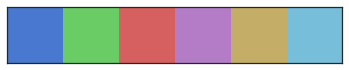

In [23]:
sns.palplot(sns.color_palette("muted"))

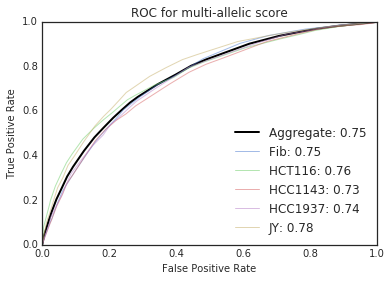

In [29]:
sns.set_style("white")
cells = cell_lines.keys()
plt.plot(FP_PHBR, TP_PHBR, c='k', lw=2, label='{0}: {1}'.format('Aggregate', str(round(metrics.auc(FP_PHBR, TP_PHBR), 2))))
for i in range(5):
    plt.plot(FP[i], TP[i], c=sns.color_palette("muted")[i], alpha=0.5, label='{0}: {1}'.format(cells[i], str(round(metrics.auc(FP[i], TP[i]), 2))))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC for multi-allelic score')
#sns.despine()
plt.savefig('/cellar/users/ramarty/Data/hla/git_data/figures/ROC.PHBR.pdf')